# TASK 2 Decision trees for classification

In [ ]:
!pip install graphviz==0.20.1
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 565.5 kB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


We required to install some frameworks as visible above.

In [ ]:
#Imports
import pandas as pd
from pandas.core.common import random_state
from pandas import Series, DataFrame
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn import metrics


# Step 1. Reading the data & Splitting

In [ ]:
data= pd.read_csv('CTG.csv', skiprows=1)
column_names = list((data.columns))
selected_cols = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
                 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
                 'Median', 'Variance', 'Tendency', 'NSP']
data_selected = data[selected_cols].dropna()  
data_selected.sample(frac = 1.0, random_state=0)
X = data_selected.drop('NSP', axis=1)
def to_label(y):
    return [None, 'normal', 'suspect', 'pathologic'][(int(y))]
y = data_selected['NSP'].apply(to_label)
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)


20% - 80% splitting technique was used.

In [ ]:
X.shape

(2126, 21)

In [ ]:
X_train.shape

(1700, 21)

In [ ]:
X_test.shape

(426, 21)

# STEP 2. Decision Tree

In [ ]:
class DecisionTreeLeaf:

    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
        graph.node(node_id, val_str, style='filled')
        return node_counter+1, node_id
        
    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False

In [ ]:
class DecisionTreeBranch:

    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then 
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter+1, node_id

In [ ]:
from graphviz import Digraph
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod

class DecisionTree(ABC, BaseEstimator):

    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth
        
    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        Y = np.array(Y)        
        self.root = self.make_tree(X, Y, self.max_depth)
        
    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph
    
    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)        

    # This is the recursive training 
    def make_tree(self, X, Y, max_depth):

        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be the most common value in Y.
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(self.best_split(X, Y, feature) for feature in range(n_features))
        
        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth-1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)
    
    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:,feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]
    
    # The following three methods need to be implemented by the classification and regression subclasses.
    
    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass

In [ ]:
from collections import Counter

class TreeClassifier(DecisionTree, ClassifierMixin):

    def __init__(self, max_depth=10, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion
        
    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return self.class_distribution.most_common(1)[0][0]
    
    # Checks whether a set of output values is homogeneous. In the classification case, 
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return len(self.class_distribution) == 1
        
    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]
            
            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i+1, low_distr, n-i-1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point

In [ ]:
def majority_sum_scorer(n_low, low_distr, n_high, high_distr):
    maj_sum_low = low_distr.most_common(1)[0][1]
    maj_sum_high = high_distr.most_common(1)[0][1]
    return maj_sum_low + maj_sum_high
    
def entropy(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return -sum(p*np.log2(p) if p > 0 else 0 for p in ps)

def info_gain_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*entropy(low_distr)+n_high*entropy(high_distr))/(n_low+n_high)

def gini_impurity(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return 1-sum(p**2 for p in ps)
    
def gini_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*gini_impurity(low_distr)+n_high*gini_impurity(high_distr))/(n_low+n_high)

# Step 3. Hyperparameter Tuning

For the hyperparameter tuning part, we tuned the max_depth parameter as desired. The training data consisted of 1700 rows and the preprocessed dataset had 23 features, which means that a maximum depth of 1699 could theoretically be used. However, this would result in overfitting, which we want to avoid. To prevent overfitting, we need to limit the depth of the decision tree. We can divide the values of each feature to get that depth. 

The complexity of a decision tree model increases as the tree grows deeper, with more splits capturing additional information about the data. However, this complexity can lead to overfitting because the model may fit the training data too well and struggle to generalize to new, unseen data. This is a common issue in decision tree models, as deeper trees can be overly complex and may not perform well on a test set.

We wanted to iterate over until scores reach the top and then decrease or iterate over until performance not improved. It is a good idea to iterate more than the number of features. So we selected 75. 

In [ ]:
max_test_accuracy_check = 0
optimum_depth_check = 0
for max_depth_index in range(0,75):
    decisionTreeImplementationModel = TreeClassifier(max_depth=max_depth_index)
    cross_validation_score = cross_val_score(decisionTreeImplementationModel, X_train, y_train)
    print("max_depth_index: ",max_depth_index ," cross validation score: ",cross_validation_score, " The mean of the score: ",cross_validation_score.mean() , " with the standard deviation: " ,cross_validation_score.std())
    if cross_validation_score.mean() > max_test_accuracy_check:
        max_test_accuracy_check = cross_validation_score.mean()
        optimum_depth_check = max_depth_index

print("max test accuracy is : ", max_test_accuracy_check," with max_depth: ", optimum_depth_check, "by observing cross validation ")



max_depth_index:  0  cross validation score:  [0.78235294 0.78235294 0.78235294 0.78235294 0.77941176]  The mean of the score:  0.7817647058823529  with the standard deviation:  0.00117647058823529
max_depth_index:  1  cross validation score:  [0.83235294 0.84411765 0.83529412 0.83235294 0.82647059]  The mean of the score:  0.8341176470588236  with the standard deviation:  0.005763505277136899
max_depth_index:  2  cross validation score:  [0.89411765 0.9        0.89117647 0.88529412 0.87647059]  The mean of the score:  0.8894117647058823  with the standard deviation:  0.008022459821756405
max_depth_index:  3  cross validation score:  [0.90882353 0.90882353 0.89705882 0.88529412 0.89117647]  The mean of the score:  0.898235294117647  with the standard deviation:  0.00941176470588235
max_depth_index:  4  cross validation score:  [0.91470588 0.91470588 0.90882353 0.90294118 0.9       ]  The mean of the score:  0.908235294117647  with the standard deviation:  0.005998846486579726
max_depth

'cross_val_score' function has a 'cv' parameter and it is 5 by default. This means that the accuracy of the model will be calculated 5 times with 5 different splits.  As you see at the bottom of the output, the best accuracy is provided by when the max_depth is equal to 10. And we can say that after the 30th step, there is not much difference between accuracies.

-----------------------------------------------------------------------------------------------------------------------------

In [ ]:
#Evaluation
max_test_accuracy = 0
optimum_depth = 0
for max_depth_index in range(0,76):
    decisionTreeImplementationModel = TreeClassifier(max_depth=max_depth_index)
    decisionTreeImplementationModel.fit(X_train,y_train)
    y_test_predicted = decisionTreeImplementationModel.predict(X_test)
    y_train_predicted = decisionTreeImplementationModel.predict(X_train)
    print('max depth is ',max_depth_index," with the test accuracy: ",accuracy_score(y_test_predicted,y_test), " and with the training accuracy: ",accuracy_score(y_train_predicted,y_train))
    test_accuracy = accuracy_score(y_test_predicted,y_test)
    if test_accuracy > max_test_accuracy:
        max_test_accuracy = test_accuracy
        optimum_depth = max_depth_index

print("max test accuracy is : ", max_test_accuracy," with max_depth: ", optimum_depth)




max depth is  0  with the test accuracy:  0.7652582159624414  and with the training accuracy:  0.7817647058823529
max depth is  1  with the test accuracy:  0.812206572769953  and with the training accuracy:  0.8341176470588235
max depth is  2  with the test accuracy:  0.8802816901408451  and with the training accuracy:  0.8894117647058823
max depth is  3  with the test accuracy:  0.8943661971830986  and with the training accuracy:  0.9047058823529411
max depth is  4  with the test accuracy:  0.8990610328638498  and with the training accuracy:  0.9176470588235294
max depth is  5  with the test accuracy:  0.903755868544601  and with the training accuracy:  0.9241176470588235
max depth is  6  with the test accuracy:  0.9014084507042254  and with the training accuracy:  0.9294117647058824
max depth is  7  with the test accuracy:  0.9014084507042254  and with the training accuracy:  0.9294117647058824
max depth is  8  with the test accuracy:  0.8990610328638498  and with the training accura

We also measure the training accuracy and test accuracy to observe if overfitting or underfitting happens. As max_depth increases, the accuracy of the training dataset is increasing. Overfitting Alert!  The peak point of the test accuracy is 0.9131455399061033. After that, the test accuracy is decreasing. So we can say that for avoiding overfitting, max_depth with 10 is the best choice.

Observation: We observed that the highest test accuracy comes with max_depth 10 and 13 with an accuracy of 0.9131455399061033. We know that max_depth with 10 is better with the different splits of the training dataset. So we will go forward with 10. 

# Step 4. Model Fitting

In [ ]:
decisionTreeImplementationModel = TreeClassifier(max_depth=10)
decisionTreeImplementationModel.fit(X_train,y_train)
y_test_predicted = decisionTreeImplementationModel.predict(X_test)
y_train_predicted = decisionTreeImplementationModel.predict(X_train)

# Step 5. Evaluation of The Model 

In [ ]:
print(metrics.classification_report(y_test, y_test_predicted))


              precision    recall  f1-score   support

      normal       0.93      0.98      0.95       326
  pathologic       0.95      0.83      0.89        42
     suspect       0.78      0.60      0.68        58

    accuracy                           0.91       426
   macro avg       0.88      0.81      0.84       426
weighted avg       0.91      0.91      0.91       426



The algorithm is working well with detecting normal and pathologic classes with in general, 91% of accuracy.

# Step 6. Tree Visualization

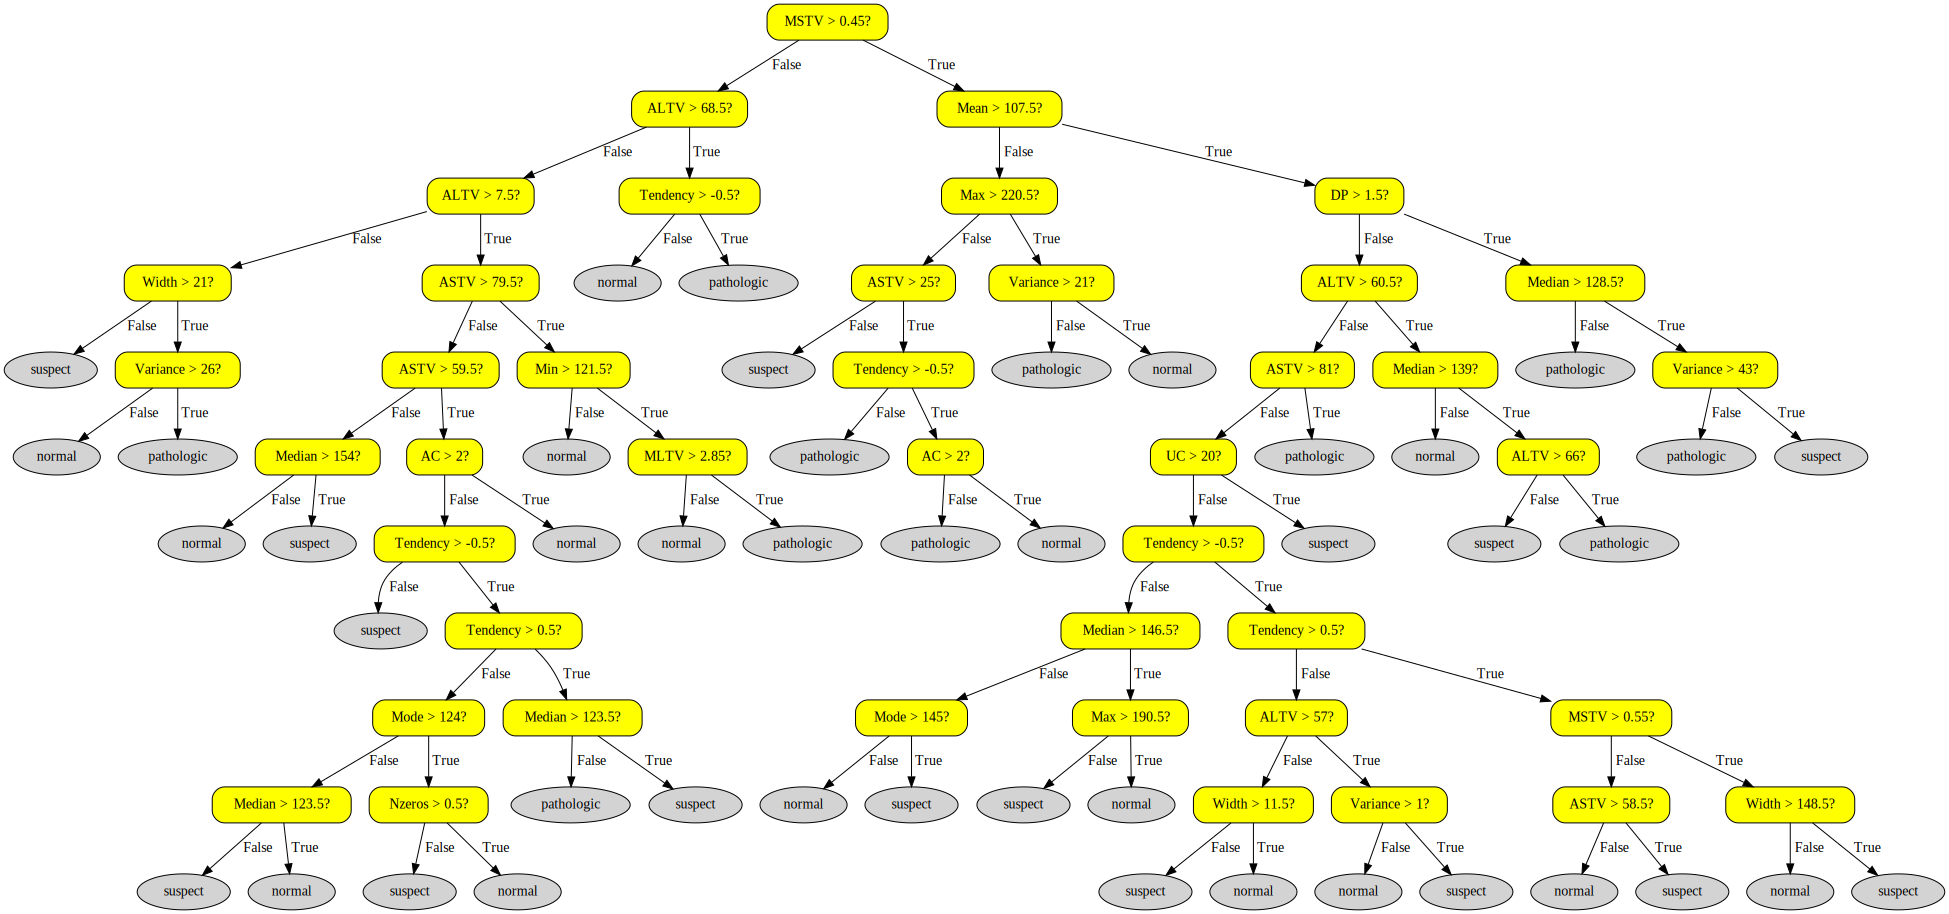

In [ ]:
decisionTreeImplementationModel.draw_tree()

Here is the decision tree visualization. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=82bb48ff-b539-4abb-b8e9-17b011c6b53b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>